In [3]:
import pandas as pd
from sklearn import preprocessing
from pandas.plotting import scatter_matrix
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
import h5py
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers

Using TensorFlow backend.


In [4]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
RANDOM_SEED = 42
LABELS = ["normal.", "ipsweep."]

In [3]:
kddCupTrain = pd.read_csv('./kddCupData/kddCupTrain.csv',header=None)
print("Shape of kddCupTrain: ",kddCupTrain.shape)
print("There are any missing values: ", kddCupTrain.isnull().values.any())
print(kddCupTrain.head(3))

Shape of kddCupTrain:  (985262, 42)
There are any missing values:  False
   0    1     2   3    4      5   6   7   8   9   10  11  12  13  14  15  16  \
0   0  tcp  http  SF  215  45076   0   0   0   0   0   1   0   0   0   0   0   
1   0  tcp  http  SF  162   4528   0   0   0   0   0   1   0   0   0   0   0   
2   0  tcp  http  SF  236   1228   0   0   0   0   0   1   0   0   0   0   0   

   17  18  19  20  21  22  23   24   25   26   27   28   29   30  31  32   33  \
0   0   0   0   0   0   1   1  0.0  0.0  0.0  0.0  1.0  0.0  0.0   0   0  0.0   
1   0   0   0   0   0   2   2  0.0  0.0  0.0  0.0  1.0  0.0  0.0   1   1  1.0   
2   0   0   0   0   0   1   1  0.0  0.0  0.0  0.0  1.0  0.0  0.0   2   2  1.0   

    34   35   36   37   38   39   40       41  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  normal.  
1  0.0  1.0  0.0  0.0  0.0  0.0  0.0  normal.  
2  0.0  0.5  0.0  0.0  0.0  0.0  0.0  normal.  


# Preparing the data

In [4]:
kddCupTrain.rename(columns={41:'Class'}, inplace=True)
kddCupTrain['Class'] = np.where(kddCupTrain['Class'] == 'normal.', 0, 1)

In [5]:
count_classes = pd.value_counts(kddCupTrain['Class'], sort = True)
print(count_classes)

0    972781
1     12481
Name: Class, dtype: int64


In [6]:
print(kddCupTrain.describe(percentiles=[]))

                   0             4             5              6         7  \
count  985262.000000  9.852620e+05  9.852620e+05  985262.000000  985262.0   
mean      215.078631  1.459258e+03  3.193730e+03       0.000007       0.0   
std      1343.633640  1.097984e+05  3.401613e+04       0.002665       0.0   
min         0.000000  0.000000e+00  0.000000e+00       0.000000       0.0   
50%         0.000000  2.300000e+02  4.060000e+02       0.000000       0.0   
max     58329.000000  8.958152e+07  1.173059e+07       1.000000       0.0   

                   8              9             10             11  \
count  985262.000000  985262.000000  985262.000000  985262.000000   
mean        0.000036       0.048908       0.000097       0.710185   
std         0.015897       0.926008       0.013058       0.453677   
min         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       1.000000   
max        14.000000      77.000000       4.00

In [10]:
kddCupTrain.columns

Index([      0,       1,       2,       3,       4,       5,       6,       8,
             9,      10,      11,      12,      13,      14,      15,      16,
            17,      18,      20,      21,      22,      23,      24,      25,
            26,      27,      28,      29,      30,      31,      32,      33,
            34,      35,      36,      37,      38,      39,      40, 'Class'],
      dtype='object')

In [9]:
columnsList = [7, 19]

kddCupTrain.drop(columnsList, axis=1, inplace=True)

In [11]:
kddCupTrain = pd.get_dummies(kddCupTrain, columns = [1, 2, 3])

In [12]:
kddCupTrain.head()

,0,4,5,6,8,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,Class,1_icmp,1_tcp,1_udp,2_IRC,2_X11,2_auth,2_ctf,2_domain,2_domain_u,2_eco_i,2_ecr_i,2_finger,2_ftp,2_ftp_data,2_gopher,2_http,2_imap4,2_link,2_mtp,2_name,2_ntp_u,2_other,2_pop_3,2_private,2_red_i,2_remote_job,2_rje,2_shell,2_smtp,2_ssh,2_telnet,2_tftp_u,2_tim_i,2_time,2_urh_i,2_urp_i,2_whois,3_OTH,3_REJ,3_RSTO,3_RSTR,3_S0,3_S1,3_S2,3_S3,3_SF,3_SH
0,0,215,45076,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,162,4528,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,236,1228,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,233,2032,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,239,486,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [13]:
featuresList = [col for col in kddCupTrain if col != 'Class']
print('featuresList: ',featuresList)

featuresList:  [0, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, '1_icmp', '1_tcp', '1_udp', '2_IRC', '2_X11', '2_auth', '2_ctf', '2_domain', '2_domain_u', '2_eco_i', '2_ecr_i', '2_finger', '2_ftp', '2_ftp_data', '2_gopher', '2_http', '2_imap4', '2_link', '2_mtp', '2_name', '2_ntp_u', '2_other', '2_pop_3', '2_private', '2_red_i', '2_remote_job', '2_rje', '2_shell', '2_smtp', '2_ssh', '2_telnet', '2_tftp_u', '2_tim_i', '2_time', '2_urh_i', '2_urp_i', '2_whois', '3_OTH', '3_REJ', '3_RSTO', '3_RSTR', '3_S0', '3_S1', '3_S2', '3_S3', '3_SF', '3_SH']


In [14]:
scaler = preprocessing.StandardScaler()
scaler.fit(kddCupTrain[featuresList]);

/anaconda3/envs/devenv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


In [15]:
kddCupTrain[featuresList] = scaler.transform(kddCupTrain[featuresList])

/anaconda3/envs/devenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [16]:
print('Mean values:')
print(kddCupTrain[featuresList].mean())
print('\nStd values:')
print(kddCupTrain[featuresList].std(ddof=0))

Mean values:
0              -3.902105e-13
4               2.406711e-15
5               1.810352e-14
6              -3.451193e-14
8              -7.015802e-15
9               4.911297e-14
10              4.875149e-15
11              4.645983e-12
12             -1.404987e-15
13              1.027645e-13
14              3.398800e-14
15             -1.289336e-14
16              1.256161e-14
17              6.611076e-14
18             -8.125271e-14
20             -2.224469e-15
21             -2.329870e-14
22             -1.583833e-13
23              1.341082e-13
24             -7.842140e-14
25              1.218339e-13
26              1.138495e-12
27             -7.429875e-13
28              1.145431e-12
29             -5.408599e-13
30              2.850148e-14
31             -9.426963e-13
32             -4.444883e-13
33              1.611694e-13
34             -1.219637e-12
35              4.962446e-13
36              3.988968e-13
37              1.790377e-13
38              3.115870e-14
3

In [21]:
X_train_split, X_test_split = train_test_split(kddCupTrain, test_size=0.2,
                                   stratify=kddCupTrain['Class'], 
                                   random_state=RANDOM_SEED)

In [22]:
y_train = X_train_split['Class']
X_train = X_train_split.drop(['Class'], axis=1)

y_test = X_test_split['Class']
X_test = X_test_split.drop(['Class'], axis=1)
print('Train: shape X',X_train.shape,', shape Y',y_train.shape)
print('Test: shape X',X_test.shape,', shape Y',y_test.shape)

Train: shape X (788209, 83) , shape Y (788209,)
Test: shape X (197053, 83) , shape Y (197053,)


In [23]:
X_trainNorm = X_train[y_train == 0]
X_trainNorm_val = X_trainNorm.values # Only values, axis labels removed. This is input for the Autoencoder
X_testNorm_val = X_test[y_test == 0].values # The validation data

In [27]:
print(y_train.shape)
print(X_train.shape)

print(X_trainNorm.shape)
print(X_trainNorm_val.shape)
print(X_testNorm_val.shape)

(788209,)
(788209, 83)
(778224, 83)
(778224, 83)
(194557, 83)


# Creating the model

In [28]:
input_dim = X_trainNorm_val.shape[1]
layer1_dim = 14
encoder_dim = 7

In [29]:
input_layer = Input(shape=(input_dim, ))

encoder1 = Dense(layer1_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder2 = Dense(encoder_dim, activation="relu")(encoder1)
decoder1 = Dense(layer1_dim, activation='tanh')(encoder2)
decoder2 = Dense(input_dim, activation='linear')(decoder1)
print('input_layer: ',input_layer)
print('encoder1',encoder1)
print('encoder2',encoder2)
print('decoder1',decoder1)
print('decoder2',decoder2)

input_layer:  Tensor("input_1:0", shape=(?, 83), dtype=float32)
encoder1 Tensor("dense_1/Tanh:0", shape=(?, 14), dtype=float32)
encoder2 Tensor("dense_2/Relu:0", shape=(?, 7), dtype=float32)
decoder1 Tensor("dense_3/Tanh:0", shape=(?, 14), dtype=float32)
decoder2 Tensor("dense_4/BiasAdd:0", shape=(?, 83), dtype=float32)


In [30]:
autoencoder = Model(inputs=input_layer, outputs=decoder2)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 83)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                1176      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 14)                112       
_________________________________________________________________
dense_4 (Dense)              (None, 83)                1245      
Total params: 2,638
Trainable params: 2,638
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error')

checkpointer = ModelCheckpoint(filepath="autoencoder.h5",
                               verbose=0,
                               save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=1, verbose=0) # 'patience' number of not improving epochs
history = autoencoder.fit(X_trainNorm_val, X_trainNorm_val,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_testNorm_val, X_testNorm_val),
                    verbose=1,
                    callbacks=[checkpointer, #tensorboard, 
                               earlystopping]).history

Train on 778224 samples, validate on 194557 samples
Epoch 1/100


# Evaluation

In [ ]:
autoencoder = load_model('autoencoder.h5')

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [ ]:
testPredictions = autoencoder.predict(X_test)
X_test.shape,testPredictions.shape

In [ ]:
testMSE = mean_squared_error(X_test.transpose(), testPredictions.transpose(),
                              multioutput='raw_values')
error_df = pd.DataFrame({'reconstruction_error': testMSE,'true_class': y_test})
error_df.head()

In [16]:
error_df = pd.read_csv('submission.csv')

In [17]:
error_df.reconstruction_error.describe()

count    196557.000000
mean          0.589971
std          20.713832
min           0.002288
25%           0.018525
50%           0.034876
75%           0.082500
max        2600.010159
Name: reconstruction_error, dtype: float64

# Reconstruction errors for normal transactions

KeyError: 'true_class'

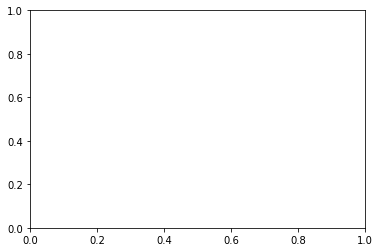

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
ax.hist(normal_error_df.reconstruction_error.values, bins=10);

# Reconstruction errors for fraudulent transactions

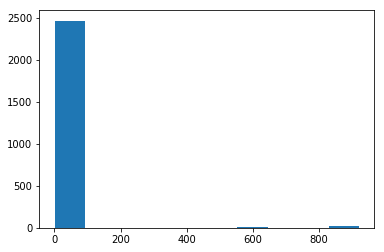

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
ax.hist(fraud_error_df.reconstruction_error.values, bins=10);

In [10]:
from sklearn.metrics import (confusion_matrix, auc, roc_curve, cohen_kappa_score, accuracy_score)

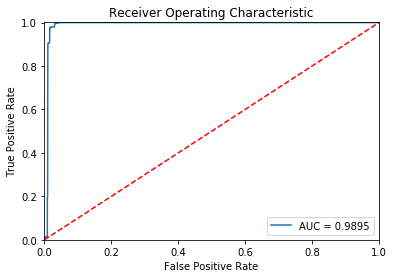

In [11]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

# Prediction

In [12]:
threshold = normal_error_df.reconstruction_error.quantile(q=0.995)
threshold

1.7027272688738235

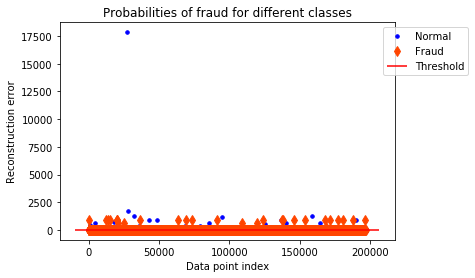

In [13]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()
for name, group in groups:
    if name == 1:
        MarkerSize = 7
        Color = 'orangered'
        Label = 'Fraud'
        Marker = 'd'
    else:
        MarkerSize = 3.5
        Color = 'b'
        Label = 'Normal'
        Marker = 'o'
    ax.plot(group.index, group.reconstruction_error, 
            linestyle='',
            color=Color,
            label=Label,
            ms=MarkerSize,
            marker=Marker)
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend(loc='upper left', bbox_to_anchor=(0.95, 1))
plt.title("Probabilities of fraud for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

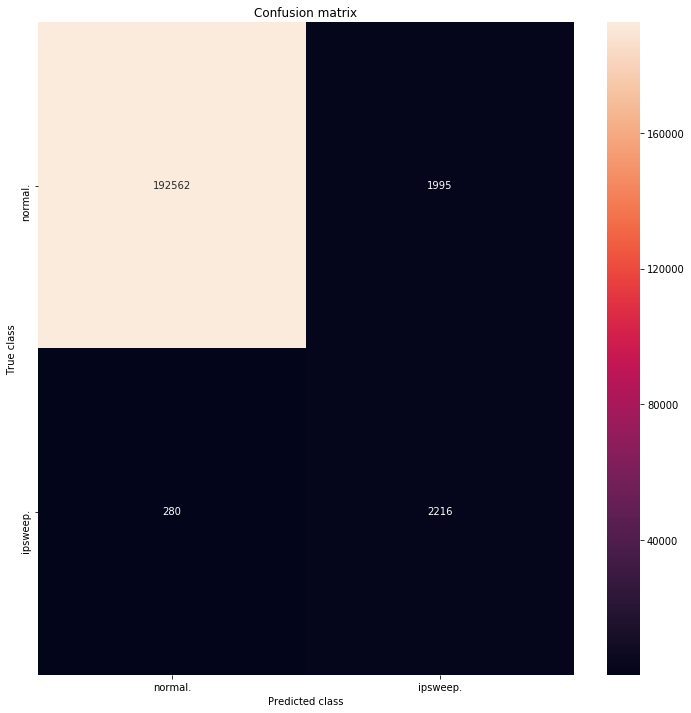

In [14]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [15]:
cohen_kappa_score(error_df.true_class, y_pred),accuracy_score(error_df.true_class, y_pred)

(0.6553198221178385, 0.9884548826965334)